In [14]:
#loading necessary libraries
library(pROC)
library(class)
library(dplyr)
library(caret)

In [15]:
#Loading dataset
data <- read.csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
#Ispecting the first rows
head(data)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,⋯,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,X
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,⋯,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NA
2,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,⋯,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NA
3,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,⋯,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NA
4,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,⋯,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NA
5,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,⋯,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NA
6,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,⋯,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NA


In [16]:
data <- data %>% select(-X)
# Remove the ID column
data <- data[, -1]
# Encode the target variable as a factor
data$diagnosis <- factor(data$diagnosis, levels = c("B", "M"), labels = c("Benign", "Malignant"))
# Split the data into training and testing sets
set.seed(42)  # For reproducibility
train_index <- createDataPartition(data$diagnosis, p = 0.8, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]
# Separate features and target variable
train_features <- train_data[, -1]
test_features <- test_data[, -1]
train_labels <- train_data$diagnosis
test_labels <- test_data$diagnosis
# Step 4: Normalize/Standardize the features
preprocess_params <- preProcess(train_features, method = c("center", "scale"))
train_features <- predict(preprocess_params, train_features)
test_features <- predict(preprocess_params, test_features)

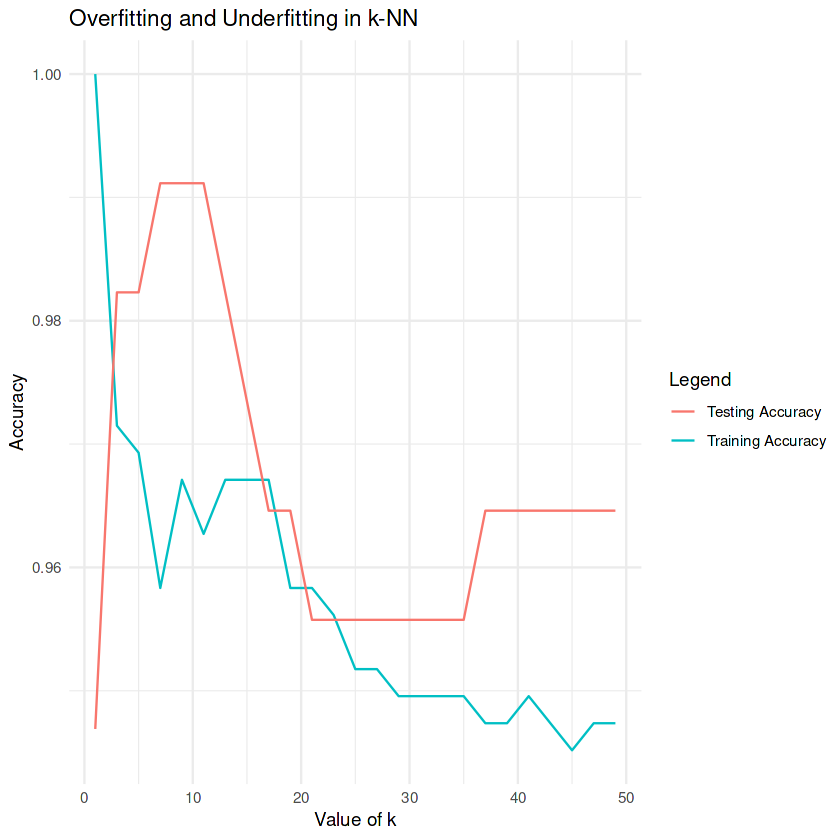

In [17]:
# Step 5: Demonstrate Overfitting and Underfitting
# Define a range of k values
k_values <- seq(1, 50, by = 2)

# Initialize vectors to store accuracy
train_accuracy <- numeric(length(k_values))
test_accuracy <- numeric(length(k_values))

# Loop through k values and evaluate model performance
for (i in seq_along(k_values)) {
  k <- k_values[i]
  
  # Train the k-NN model
  knn_train_predictions <- knn(train = train_features, test = train_features, cl = train_labels, k = k)
  knn_test_predictions <- knn(train = train_features, test = test_features, cl = train_labels, k = k)
  
  # Calculate accuracy on training and testing sets
  train_accuracy[i] <- sum(knn_train_predictions == train_labels) / length(train_labels)
  test_accuracy[i] <- sum(knn_test_predictions == test_labels) / length(test_labels)
}

# Step 6: Plot the results
results <- data.frame(k = k_values, Train_Accuracy = train_accuracy, Test_Accuracy = test_accuracy)
ggplot(results, aes(x = k)) +
  geom_line(aes(y = Train_Accuracy, color = "Training Accuracy")) +
  geom_line(aes(y = Test_Accuracy, color = "Testing Accuracy")) +
  labs(title = "Overfitting and Underfitting in k-NN",
       x = "Value of k",
       y = "Accuracy",
       color = "Legend") +
  theme_minimal()

In [18]:
# Step 7: Hyperparameter Tuning with an if-else loop
# Initialize variables to store the best k and its accuracy
best_k <- k_values[1]
best_accuracy <- test_accuracy[1]

# Loop through k values to find the best k
for (i in seq_along(k_values)) {
  k <- k_values[i]
  current_accuracy <- test_accuracy[i]
  
  # Update best k if current accuracy is better
  if (current_accuracy > best_accuracy) {
    best_k <- k
    best_accuracy <- current_accuracy
  }
}

# Print the best k and its accuracy
print(paste("Best k:", best_k))
print(paste("Best Testing Accuracy:", best_accuracy))

[1] "Best k: 7"
[1] "Best Testing Accuracy: 0.991150442477876"


In [20]:
#Applying knn algorithm
knn_predictions <- knn(train = train_features, test = test_features, cl = train_labels, k = best_k)
#Evaluate the model
conf_matrix <- confusionMatrix(knn_predictions, test_labels)
print(conf_matrix)
# Accuracy
accuracy <- conf_matrix$overall["Accuracy"]
print(paste("Accuracy:", accuracy))

Confusion Matrix and Statistics

           Reference
Prediction  Benign Malignant
  Benign        70         0
  Malignant      1        42
                                          
               Accuracy : 0.9912          
                 95% CI : (0.9517, 0.9998)
    No Information Rate : 0.6283          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9811          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9859          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9767          
             Prevalence : 0.6283          
         Detection Rate : 0.6195          
   Detection Prevalence : 0.6195          
      Balanced Accuracy : 0.9930          
                                          
       'Positive' Class : Benign          